In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import torch
import torch.nn as nn
import random

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [2]:
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=False

In [3]:
data_path = "train/new_joints_vecs/"
label_path = "train/original_texts/"

action_to_desc = {
        "bend and pull full" : 0,
        "countermovement jump" : 1,
        "left countermovement jump" : 2,
        "left lunge and twist" : 3,
        "left lunge and twist full" : 4,
        "right countermovement jump" : 5,
        "right lunge and twist" : 6,
        "right lunge and twist full" : 7,
        "right single leg squat" : 8,
        "squat" : 9,
        "bend and pull" : 10,
        "left single leg squat" : 11,
        "push up" : 12
    }

In [4]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import torch.optim as optim

class CustomDataset(Dataset):
    def __init__(self, action_to_desc, max_seq_len, stride, mode):
        data_path = mode + "/new_joints_vecs/"
        self.data_path_mot = mode + "/mot_data/"
        label_path = mode + "/original_texts/"
        # self.mcs_path = mode + "/mcs/"
        self.data_path = data_path
        self.label_path = label_path
        self.action_to_desc = action_to_desc
        self.max_seq_len = max_seq_len
        self.stride = stride
        self.samples = []
        
        class_counter = Counter()
        
        files = os.listdir(data_path)
        print("Len num samples in file:", len(files))
        for file in files:
            if not file.endswith('.npy'):
                continue
            # data_file = np.load(data_path + file)
            txt_file = file.replace('.npy','.txt')
            label_file = label_path + txt_file
            # mcs_file = self.mcs_path + txt_file
            # if not os.path.isfile(mcs_file):
            #     mcs_score = -1
            # else:
            #     with open(mcs_file, 'r') as f:
            #         mcs_score = f.readlines()
            #         mcs_score = float(mcs_score[0])
            with open(label_file, 'r') as f:
                label_text = f.readlines()
            label = action_to_desc[label_text[0]]
            class_counter[label] += 1
            self.samples.append((data_path + file, label))

        # Calculate the maximum frequency of any class
        max_class_frequency = max(class_counter.values())

        # Calculate the sampling weight for each class
        self.class_weights = {cls: max_class_frequency / freq for cls, freq in class_counter.items()}
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        while True:
            file, label = self.samples[idx]
            data_file = np.load(file)
            # mot_file = self.data_path_mot + file.split('/')[-1]
            # mot_file = np.load(mot_file)
            
            # data_file = np.concatenate((data_file,mot_file[:-1]), axis = 1)
            # print(data_file.shape)
            
            # Determine sampling probability based on class frequency
            sampling_prob = 1 / self.class_weights[label]

            # Perform sampling based on the calculated probability
            if np.random.uniform() < sampling_prob:
                if data_file.shape[0] <= self.max_seq_len*self.stride:
                    padded_data = np.zeros((self.max_seq_len, data_file.shape[1]))
                    temp = data_file[::self.stride,:]
                    padded_data[:temp.shape[0], :] = temp
                    data_file = padded_data
                    start = 0
                else:
                    # print(len(data_file), max_seq_len)
                    i = np.random.randint(0,len(data_file)-self.max_seq_len*self.stride)
                    data_file = data_file[i:i+self.max_seq_len*self.stride:self.stride, :]
                    start = i
                # print(data_file.shape)
                
                # Only take every alternate time stamp
                alternate_data = data_file # Take every alternate row
                # print(alternate_data, label, start, file)
                return alternate_data, label, start, file

In [5]:
max_seq_len = 50
batch_size = 512
stride = 3

train_dataset = CustomDataset(action_to_desc, max_seq_len, stride, mode="train")
train_dataset.samples = [sample for sample in train_dataset.samples if sample[0] is not None]
test_dataset = CustomDataset(action_to_desc, max_seq_len, stride, mode="eval")
test_dataset.samples = [sample for sample in test_dataset.samples if sample[0] is not None]

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Len num samples in file: 1491
Len num samples in file: 413


In [6]:
input_size = max_seq_len * 263
hidden_size1 = 256
hidden_size2 = 256
num_classes = 13 #len(np.unique(Y))  # Assuming Y contains integer labels
learning_rate = 0.0005
num_epochs = 100

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc3_lab = nn.Linear(hidden_size1, num_classes)
        # self.dp = nn.Dropout(0)
        self.relu = nn.ReLU()

    def forward(self, x, return_embeddings = False):
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x)) 
        if return_embeddings:
            return x
        # x = self.relu(self.fc2(x)) + x
        x_lab = self.fc3_lab(x)
        # x_mcs = self.fc3_mcs(x)
        return x_lab #, x_mcs

# Create an instance of the MLP model
model = MLP(input_size, hidden_size1, hidden_size2, num_classes).to('cuda')

criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct, total

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float()  # Convert inputs to float
        optimizer.zero_grad()
        outputs_lab= model(inputs.to('cuda'))
        
        loss_lab = criterion(outputs_lab, labels.type(torch.long).to('cuda'))
        loss = loss_lab.mean()
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
        model.eval()
        correct_lab = 0
        total_lab = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.float()  # Convert inputs to float
                labels = labels.to('cuda')
                outputs_lab = model(inputs.to('cuda'))
                # Calculate label accuracy
                correct, total = calculate_accuracy(outputs_lab, labels)
                correct_lab += correct
                total_lab += total
            # Print accuracy
            print(f"Label Accuracy on test set: {(correct_lab / total_lab) * 100}%")


ValueError: too many values to unpack (expected 2)

In [11]:
model.eval()
torch.save(model.state_dict(), "MCS_classifier_anwesh.pt")

In [55]:
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []
    start = []
    files = []
    with torch.no_grad():
        for inputs, lab, start_point, file_name in dataloader:
            inputs = inputs.float().to('cuda')
            emb = model(inputs, return_embeddings=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(lab.cpu().numpy())
            # print(start_point)
            start.append(start_point.cpu().numpy())
            file_name = list(file_name)
            # print(file_name)
            files.append(file_name)
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    start = np.hstack(start)
    files = np.hstack(files)
    return embeddings, labels, start, files

In [56]:
# Extract and store training embeddings
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
train_embeddings, train_labels, train_start_points, train_files = extract_embeddings(train_loader, model)

# Extract and store test embeddings
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_embeddings, test_labels, test_start_points, test_files = extract_embeddings(test_loader, model)

/home/ubuntu/.conda/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ubuntu/.conda/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


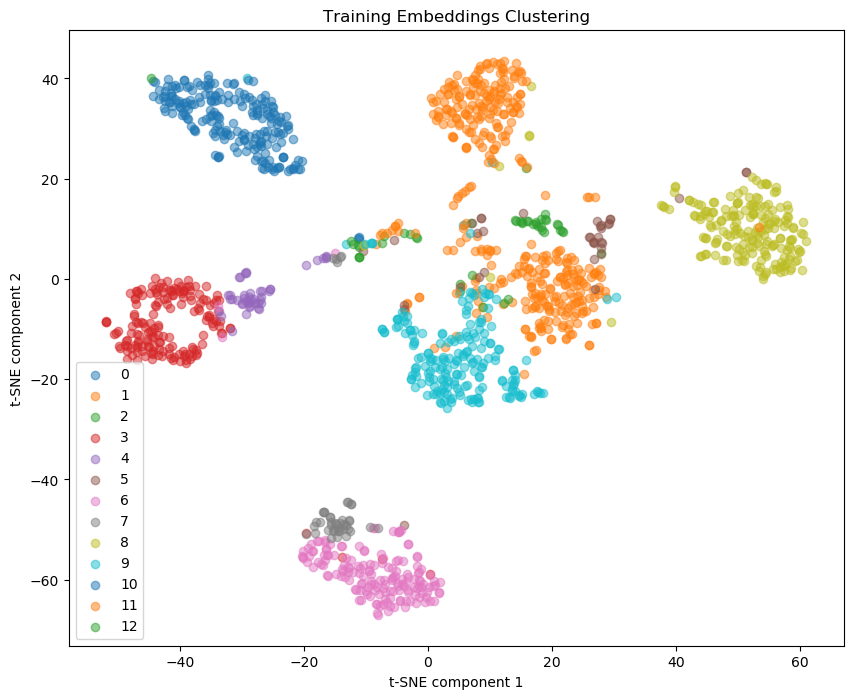

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Function to plot embeddings
def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label, alpha=0.5)

    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

# Visualize training embeddings
plot_embeddings(train_embeddings, train_labels, 'Training Embeddings Clustering')

/home/ubuntu/.conda/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ubuntu/.conda/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


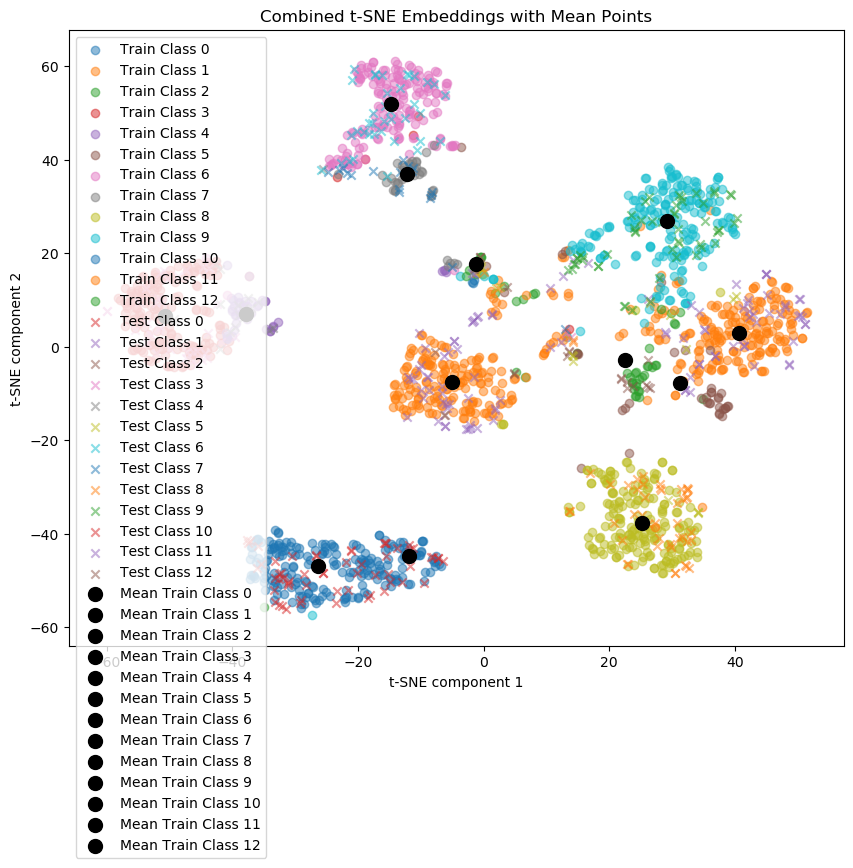

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.covariance import EllipticEnvelope

# Step 1: Combine Train and Test Data
combined_embeddings = np.vstack((train_embeddings, test_embeddings))
combined_labels = np.hstack((train_labels, test_labels))
combined_is_train = np.hstack((np.ones(len(train_labels)), np.zeros(len(test_labels))))
comined_names = np.hstack((train_files, test_files))

# Step 2: Calculate t-SNE embeddings for the combined data
tsne = TSNE(n_components=2, random_state=42)
combined_tsne_embeddings = tsne.fit_transform(combined_embeddings)

# Step 3: Separate the transformed data back into train and test sets
train_tsne_embeddings = combined_tsne_embeddings[combined_is_train == 1]
test_tsne_embeddings = combined_tsne_embeddings[combined_is_train == 0]

# Step 4: Identify and remove outliers in the t-SNE space
def get_mean_embeddings_in_tsne_space(tsne_embeddings, labels):
    mean_embeddings = {}
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Get t-SNE embeddings for the current label
        label_embeddings = tsne_embeddings[labels == label]
        
        # Use EllipticEnvelope to identify and remove outliers
        ee = EllipticEnvelope(contamination=0.1)  # Adjust contamination to control the percentage of outliers
        ee.fit(label_embeddings)
        inliers = ee.predict(label_embeddings) == 1
        
        # Filter out the outliers
        filtered_embeddings = label_embeddings[inliers]
        
        # Calculate the mean of the remaining points
        mean_of_best_samples = np.mean(filtered_embeddings, axis=0)
        
        # Store the result
        mean_embeddings[label] = mean_of_best_samples
    
    return mean_embeddings

# Calculate mean embeddings in t-SNE space for the training data
mean_tsne_embeddings = get_mean_embeddings_in_tsne_space(train_tsne_embeddings, train_labels)

# Step 5: Plot the combined t-SNE embeddings with mean points
def plot_combined_tsne_with_means(train_tsne_embeddings, train_labels, test_tsne_embeddings, test_labels, mean_tsne_embeddings, title):
    plt.figure(figsize=(10, 8))
    
    # Plot train data
    for label in np.unique(train_labels):
        indices = np.where(train_labels == label)
        plt.scatter(train_tsne_embeddings[indices, 0], train_tsne_embeddings[indices, 1], label=f'Train Class {label}', alpha=0.5)
    
    # Plot test data
    for label in np.unique(test_labels):
        indices = np.where(test_labels == label)
        plt.scatter(test_tsne_embeddings[indices, 0], test_tsne_embeddings[indices, 1], label=f'Test Class {label}', alpha=0.5, marker='x')
    
    # Plot mean points
    for label, mean_embedding in mean_tsne_embeddings.items():
        plt.scatter(mean_embedding[0], mean_embedding[1], color='black', marker='o', s=100, label=f'Mean Train Class {label}')

    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

# Plot the combined t-SNE embeddings with mean points
plot_combined_tsne_with_means(train_tsne_embeddings, train_labels, test_tsne_embeddings, test_labels, mean_tsne_embeddings, 'Combined t-SNE Embeddings with Mean Points')


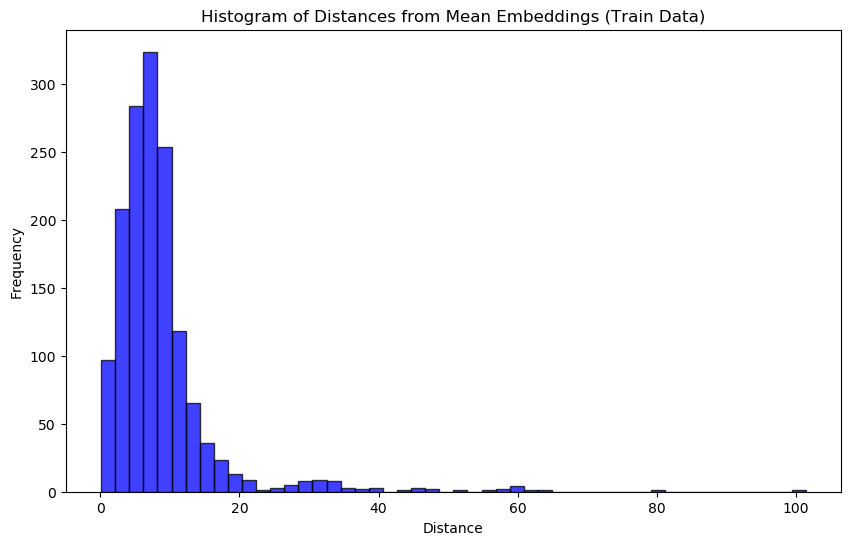

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate the distances for train and test embeddings from their respective mean points
def calculate_distances_to_means(tsne_embeddings, labels, mean_tsne_embeddings):
    distances = np.zeros(len(labels))
    for i, (embedding, label) in enumerate(zip(tsne_embeddings, labels)):
        mean_embedding = mean_tsne_embeddings[label]
        distance = np.linalg.norm(embedding - mean_embedding)
        distances[i] = distance
    return distances

# Calculate distances for train and test embeddings
train_distances = calculate_distances_to_means(train_tsne_embeddings, train_labels, mean_tsne_embeddings)
test_distances = calculate_distances_to_means(test_tsne_embeddings, test_labels, mean_tsne_embeddings)

# Step 2: Visualize the distances for the train data
plt.figure(figsize=(10, 6))
plt.hist(train_distances, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Distances from Mean Embeddings (Train Data)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Step 3: Assign scores based on distance thresholds (optional)
# You can determine the thresholds visually from the histogram and then use them to assign scores
# For example:
# thresholds = [threshold1, threshold2, threshold3, threshold4]
# scores = np.digitize(train_distances, bins=thresholds)


In [61]:
# Step 1: Define the thresholds
thresholds = [2, 4, 8, 10]

# Step 2: Function to assign scores based on thresholds
def assign_scores(distances, thresholds):
    scores = np.zeros(len(distances), dtype=int)
    for i, distance in enumerate(distances):
        if distance < thresholds[0]:
            scores[i] = 5
        elif distance < thresholds[1]:
            scores[i] = 4
        elif distance < thresholds[2]:
            scores[i] = 3
        elif distance < thresholds[3]:
            scores[i] = 2
        else:
            scores[i] = 1
    return scores

# Step 3: Assign scores to train and test distances
train_scores = assign_scores(train_distances, thresholds)
test_scores = assign_scores(test_distances, thresholds)

# Print the results
print("Train Scores:", train_scores)
print("Test Scores:", test_scores)

Train Scores: [2 3 3 ... 5 4 3]
Test Scores: [4 2 3 3 3 3 1 1 3 1 3 4 1 1 1 1 2 5 3 1 4 1 3 3 5 5 3 3 2 2 3 4 1 3 3 1 5
 1 4 1 2 3 2 4 3 2 2 1 3 1 3 1 1 2 2 1 2 2 3 1 4 3 2 1 4 3 3 5 1 2 3 4 3 1
 1 1 3 1 1 3 1 3 2 5 3 3 4 1 1 3 3 3 3 1 1 2 3 3 1 3 2 3 1 3 4 3 1 1 3 3 3
 2 1 1 1 1 1 5 2 1 1 2 4 2 1 1 1 4 1 3 2 1 2 2 4 1 2 1 3 1 4 3 2 5 3 2 2 3
 1 3 1 1 2 2 1 1 2 5 3 5 4 1 3 1 3 3 1 2 3 3 3 1 3 3 5 3 3 5 3 1 3 3 3 1 2
 3 2 2 1 1 1 1 3 4 3 3 3 1 1 3 3 1 1 5 2 3 1 2 1 4 1 1 3 4 2 5 1 3 1 5 1 1
 1 1 2 4 3 2 3 1 1 1 1 3 4 4 3 1 4 2 3 4 1 3 2 4 5 3 1 2 1 3 1 3 5 2 4 1 1
 3 1 3 1 2 3 1 5 1 1 3 1 4 1 2 3 2 1 2 3 1 2 2 1 1 3 4 3 1 2 3 3 1 1 3 1 1
 1 3 2 2 2 3 3 1 3 1 5 1 2 5 3 3 1 1 3 3 2 1 1 4 1 2 5 1 3 1 3 3 4 3 4 1 1
 4 1 1 4 5 3 1 1 3 3 3 1 3 1 3 1 1 1 3 3 2 4 2 3 4 4 1 3 2 3 2 3 3 4 4 3 1
 1 2 1 3 3 5 2 4 3 1 2 2 1 4 3 1 2 1 3 1 1 2 1 3 2 3 1 3 5 2 1 2 1 1 3 4 2
 4 1 1 4 1 5]


In [62]:
combined_scores = np.hstack((train_scores, test_scores))

In [64]:
for name, score in zip(comined_names,combined_scores):
    mode = name.split('/')[0]
    fname = name.split('/')[-1].split('.')[0]
    save_path = mode + "/new_score/" + fname + ".txt"
    with open(save_path, 'w') as f:
        f.write(str(score))